Anomaly detection involves finding irregular activities like financial  frarud, suspecious, acces, malfunction of machines ,etc 
Today we are going to talk about anomaly detection using a multivariate time series data based on industrial control systems data.
Its worth mentioning anomaly detection  is not onnly a bout finding suspecious activities but also  about positiev events such  as trending type of posts  in a blog or products sold .




In [71]:
# Main 
import os
import pandas as pd
import numpy as np
from pathlib import Path  
from datetime import date
# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.simplefilter('ignore')

In [72]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result
"""Multivariate Time Series"""
occ_data = pd.read_csv('dataset/hai_data.csv',parse_dates=['time'])
#occ_data = occ_data.set_index('time')
occ_data.head()

,time,P1_B3004,P1_B3005,P1_B4002,P1_FCV01D,P1_FCV03D,P1_FT03,P1_LCV01D,P1_LIT01,P1_PCV01D,P1_PIT01,P2_CO_rpm,P2_RTR,P2_SIT01,P2_VTR01,P2_VTR02,P3_LCP01D,attack
0,2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.69160,69.76647,315.48346,13.97231,384.30737,83.46329,1.35437,54065.0,2880,774.0,10,10,136,0
1,2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.64934,69.74272,315.10199,13.93358,384.30737,83.40041,1.35437,54073.0,2880,773.0,10,10,136,0
2,2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.91075,69.77000,316.05570,13.95248,384.20517,83.34054,1.35513,54073.0,2880,773.0,10,10,136,0
3,2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.92407,69.70607,315.10199,13.89971,384.25626,83.26884,1.35513,54086.0,2880,777.0,10,10,136,0
4,2020-07-09 15:00:00,382.21698,1118.61084,32.0,93.05405,69.76971,315.48346,13.94603,384.20517,83.18826,1.35437,54086.0,2880,778.0,10,10,136,0


In [73]:
df_day = pd.DataFrame()

df_day['P1_LIT01'] = occ_data.groupby(occ_data.time)['P1_LIT01'].sum()
df_day['P1_LCV01D'] = occ_data.groupby(occ_data.time)['P1_LCV01D'].sum()
df_day['attack'] = occ_data.groupby(occ_data.time)['attack'].sum()

df_day.index = pd.DatetimeIndex(df_day.index.values, freq=df_day.index.inferred_freq)

<AxesSubplot:>

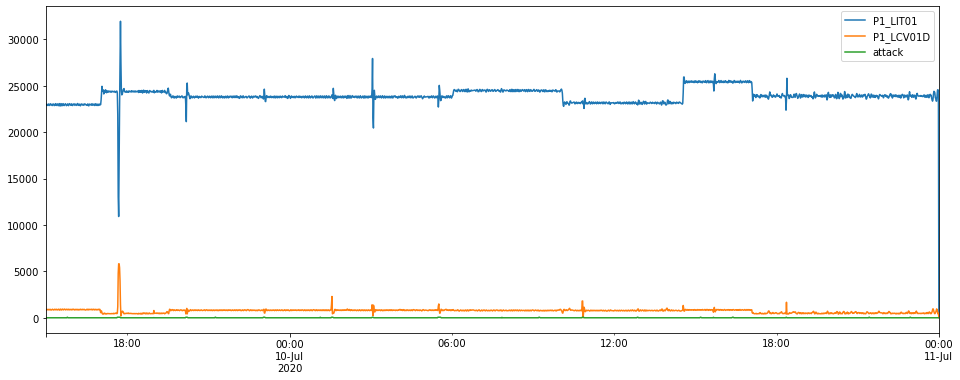

In [48]:
df_day.plot(figsize=(16,6))


In [49]:
### TRAIN SPLIT ###
train_hours = 160*7*24
train = df_day[:(train_hours//24)].copy()
train.shape

(1120, 3)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

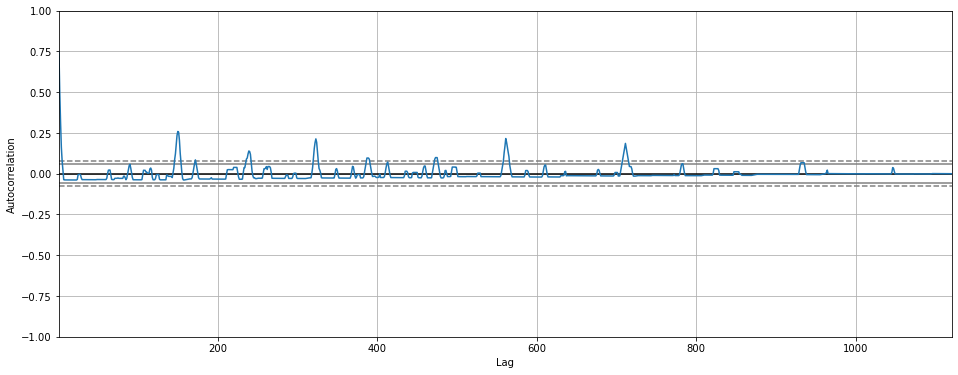

In [50]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['attack'])

In [51]:
month_mean_train = train.groupby(train.index.day).mean()


In [52]:
train['attack'] = train.apply(lambda x: x['attack'] - month_mean_train['attack'][x.name.day], axis=1)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

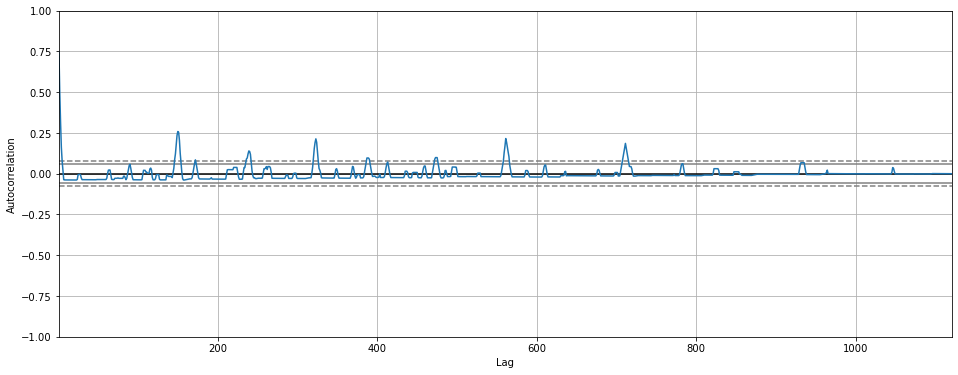

In [53]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['attack'])

In [59]:
### TRAIN TEST SPLIT IN UNIVARIATE CASE ###

train_uni = train['attack'].copy()
test_uni = df_day['attack'][(train_hours//24):].copy()
test_uni = test_uni - test_uni.index.day.map(month_mean_train['attack'])

train.drop('attack', inplace=True, axis=1)

In [60]:
### FIND BEST UNIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

for p in range(6,9):
    for q in range(0,10):

        mod = SARIMAX(train_uni, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            AIC[(p,0,q)] = res.aic
        except:
            AIC[(p,0,q)] = np.inf
            
        if AIC[(p,0,q)] < best_aic:
            best_aic = AIC[(p,0,q)]
            best_order = (p,0,q)
            
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (8, 0, 5) BEST AIC: 7538.009840075209


In [61]:
### TRAIN BEST UNIVARIATE MODEL ###

mod = SARIMAX(train_uni, order=best_order, enforce_invertibility=False)
res = mod.fit(disp=False)
res.aic

7538.009840075209

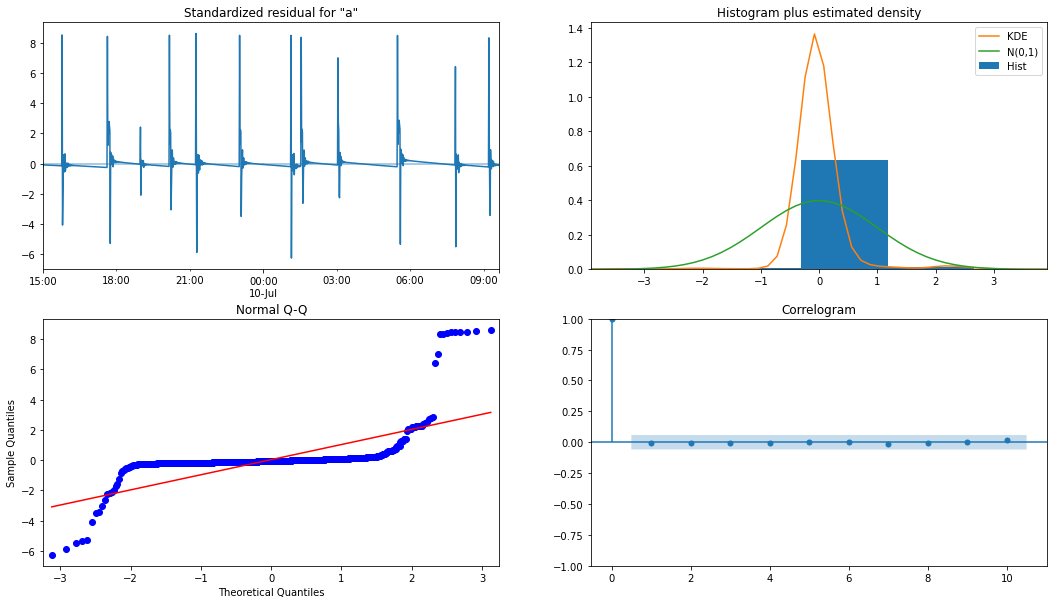

In [62]:
### PERFORMANCE OPTINAL MODEL ###

res.plot_diagnostics(figsize=(18,10))
plt.show()

In [64]:
### GET TRAIN FITTED VALUES ###

predict = res.get_prediction()
predicted_mean = predict.predicted_mean + predict.predicted_mean.index.day.map(month_mean_train['attack'])
train_uni = train_uni + train_uni.index.day.map(month_mean_train['attack'])
predict_ci = predict.conf_int(alpha=0.1)
predict_ci['lower attack'] = predict_ci.apply(lambda x: x['lower attack'] + month_mean_train['attack'][x.name.day], axis=1)
predict_ci['upper attack'] = predict_ci.apply(lambda x: x['upper attack'] + month_mean_train['attack'][x.name.day], axis=1)

residuals_mean = res.resid.mean()
residuals_std = res.resid.std()


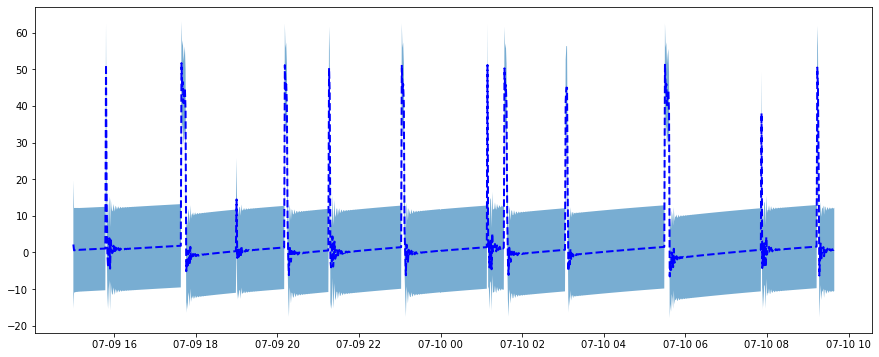

In [65]:
### PLOT TRAIN FITTED VALUES ###

plt.figure(figsize=(15,6))

plt.plot(train_uni, 'k.')
plt.plot(predicted_mean, linestyle='--', linewidth=2, color='blue')
plt.fill_between(predict_ci.index, predict_ci['lower attack'], predict_ci['upper attack'], alpha=0.6)

In [67]:
point_forecast = res.get_prediction(end=mod.nobs)
point_ci = point_forecast.conf_int(alpha=0.1)

mean_pred = {point_forecast.predicted_mean.index[-1]: point_forecast.predicted_mean[-1]}
upper_pred = {point_ci.index[-1]: point_ci['upper attack'][-1]}
lower_pred = {point_ci.index[-1]: point_ci['lower attack'][-1]}

for t,row in test_uni[:-1].iteritems():
    
    row = pd.Series(row, index=[t])
    res = res.extend(row)
    point_forecast = res.get_prediction(1)
    point_ci = point_forecast.conf_int(alpha=0.1)
    
    mean_pred[point_forecast.predicted_mean.index[0]] = point_forecast.predicted_mean.values[0]
    upper_pred[point_ci.index[0]] = point_ci['upper attack'][0]
    lower_pred[point_ci.index[0]] = point_ci['lower attack'][0]
    
mean_pred = pd.Series(mean_pred)
upper_pred = pd.Series(upper_pred)
lower_pred = pd.Series(lower_pred)

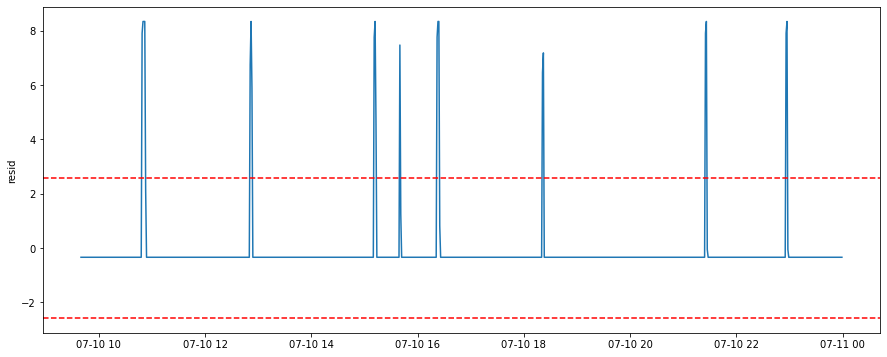

In [68]:
### TEST RESIDUALS ANALYSIS ###

alpha = 0.01
upper = stats.norm.ppf(1 - alpha/2)
lower = stats.norm.ppf(alpha/2)

residuals_test = test_uni - residuals_mean
residuals_test = (residuals_test - residuals_mean) / residuals_std

plt.figure(figsize=(15,6))
plt.plot(residuals_test)
plt.ylabel('resid')
plt.axhline(upper, c='red', linestyle='--')
plt.axhline(lower, c='red', linestyle='--')

In [69]:
### REVERSE SCALING TEST ITERATIVE PREDICTIONS ###

mean_pred = mean_pred + mean_pred.index.day.map(month_mean_train['attack'])
upper_pred = upper_pred + upper_pred.index.day.map(month_mean_train['attack'])
lower_pred = lower_pred + lower_pred.index.day.map(month_mean_train['attack'])
test_uni = test_uni + test_uni.index.day.map(month_mean_train['attack'])

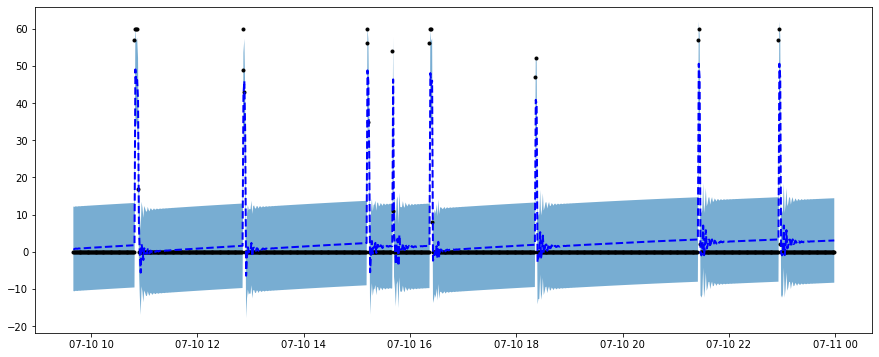

In [70]:
### PLOT TEST ITERATIVE PREDICTIONS ###

plt.figure(figsize=(15,6))

plt.plot(test_uni, 'k.')
plt.plot(mean_pred, linestyle='--', linewidth=2, color='blue')
plt.fill_between(mean_pred.index, lower_pred, upper_pred, alpha=0.6)

In [54]:
### FIND BEST MULTIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train)
    var_result = model.fit(maxlags=i)
    AIC[i] = var_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 10 BEST AIC: 25.024414747859932


In [55]:
var = VAR(endog=train)
var_result = var.fit(maxlags=best_order)

var_result.aic

25.024414747859932

In [56]:

residuals_mean = var_result.resid.values.mean(axis=0)
residuals_std = var_result.resid.values.std(axis=0)

residuals = (var_result.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))

In [57]:

m = var_result.nobs
p = var_result.resid.shape[-1]
alpha = 0.01

UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) *(p*(m+1)*(m-1)/(m*m-m*p))
UCL

11.428910091639649

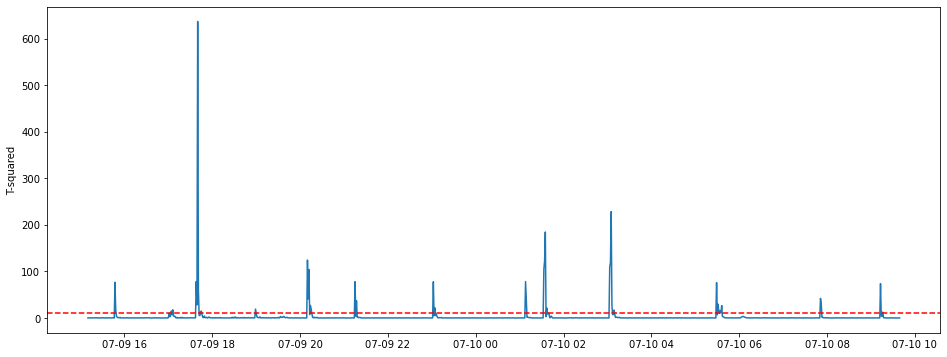

In [58]:
### PLOT TRAIN T2 METRIC ###

plt.figure(figsize=(16,6))
plt.plot(train.index[best_order:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [84]:
df = pd.read_csv('dataset/hai_data.csv',parse_dates=['time'],  index_col='time')
#occ_data = occ_data.set_index('time')
df.head()

,P1_B3004,P1_B3005,P1_B4002,P1_FCV01D,P1_FCV03D,P1_FT03,P1_LCV01D,P1_LIT01,P1_PCV01D,P1_PIT01,P2_CO_rpm,P2_SIT01,P3_LCP01D,attack
time,,,,,,,,,,,,,,
2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.69160,69.76647,315.48346,13.97231,384.30737,83.46329,1.35437,54065.0,774.0,136,0
2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.64934,69.74272,315.10199,13.93358,384.30737,83.40041,1.35437,54073.0,773.0,136,0
2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.91075,69.77000,316.05570,13.95248,384.20517,83.34054,1.35513,54073.0,773.0,136,0
2020-07-09 15:00:00,382.21698,1118.61084,32.0,92.92407,69.70607,315.10199,13.89971,384.25626,83.26884,1.35513,54086.0,777.0,136,0
2020-07-09 15:00:00,382.21698,1118.61084,32.0,93.05405,69.76971,315.48346,13.94603,384.20517,83.18826,1.35437,54086.0,778.0,136,0


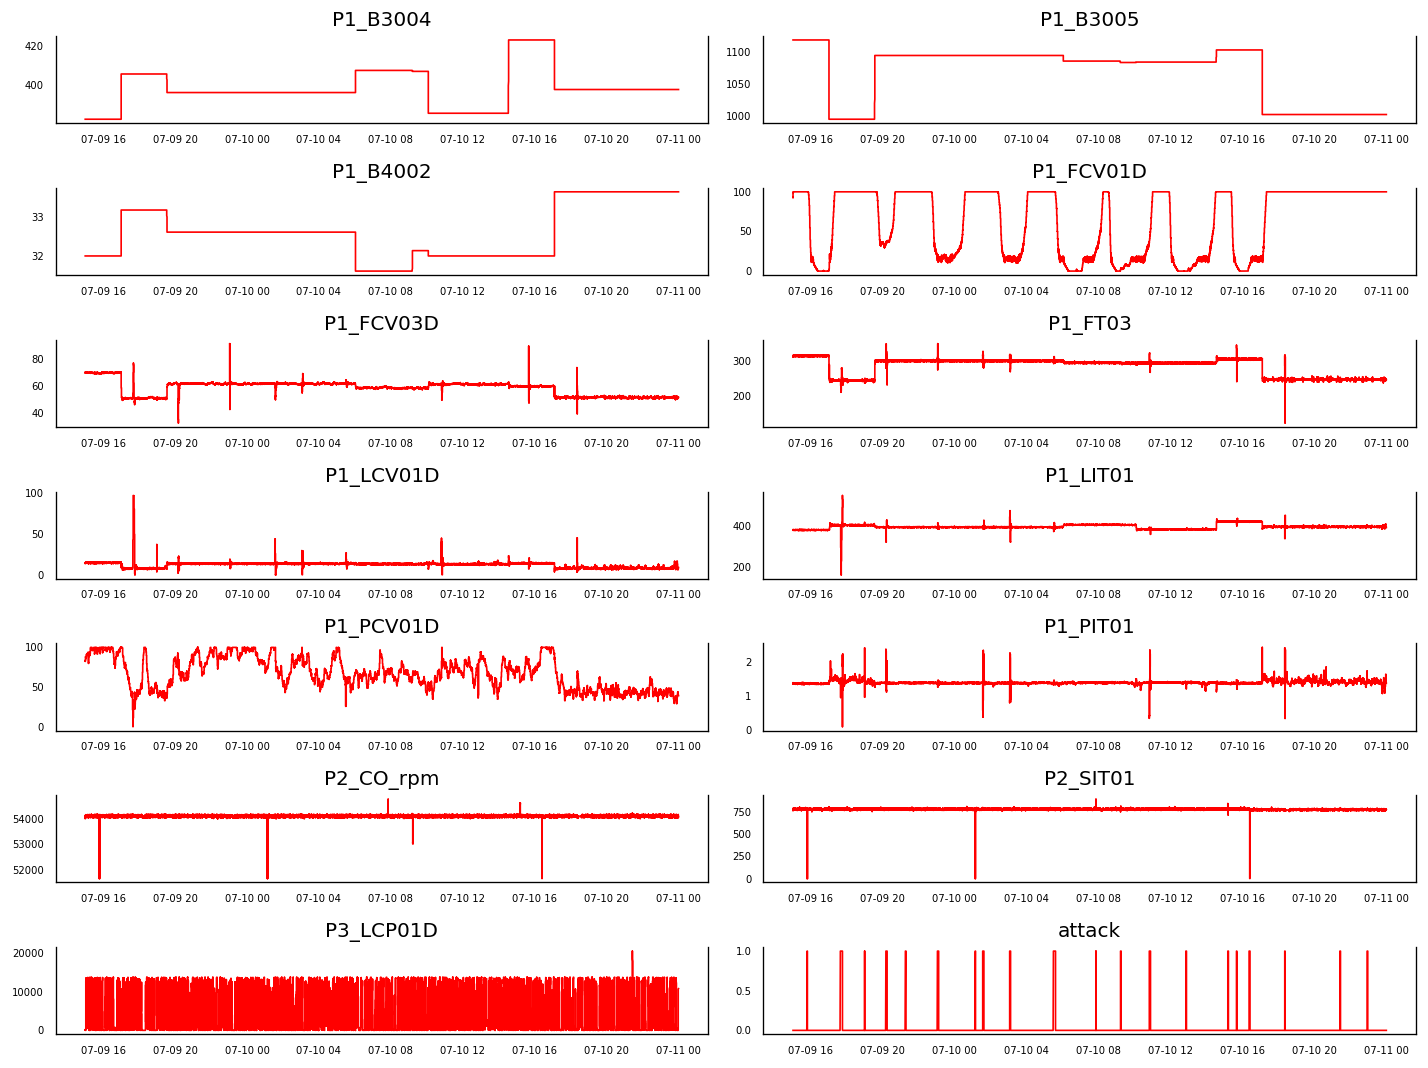

In [90]:
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=120, figsize=(12,9))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [91]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


grangers_causation_matrix(df, variables = df.columns)  

,P1_B3004_x,P1_B3005_x,P1_B4002_x,P1_FCV01D_x,P1_FCV03D_x,P1_FT03_x,P1_LCV01D_x,P1_LIT01_x,P1_PCV01D_x,P1_PIT01_x,P2_CO_rpm_x,P2_SIT01_x,P3_LCP01D_x,attack_x
P1_B3004_y,1.0000,0.0000,0.0000,0.0346,0.0000,0.0099,0.0000,0.0000,0.0506,0.0003,0.4214,0.6790,0.3880,0.8806
P1_B3005_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.7535,0.3738,0.0000,0.0019,0.0988,0.6387,0.0077,0.6665
P1_B4002_y,0.0041,0.0000,1.0000,0.0000,0.0000,0.0000,0.6565,0.0012,0.0000,0.0132,0.0250,0.6488,0.3024,0.6351
P1_FCV01D_y,0.1185,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.2964,0.2981,0.0000,0.4892,0.5551,0.0928,0.1297
P1_FCV03D_y,0.0002,0.0000,0.0000,0.0013,1.0000,0.0000,0.0000,0.0000,0.0000,0.0060,0.8634,0.6920,0.0820,0.0000
P1_FT03_y,0.0506,0.0000,0.0000,0.0555,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.2889,0.6309,0.2179,0.0000
P1_LCV01D_y,0.0000,0.0000,0.0000,0.1914,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0346,0.2160,0.0000,0.0000
P1_LIT01_y,0.0000,0.0000,0.0000,0.6939,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0284,0.0555,0.0000,0.0000
P1_PCV01D_y,0.0000,0.0000,0.0000,0.5929,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0048,0.0000,0.0000
P1_PIT01_y,0.0000,0.0000,0.0000,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.3336,0.7454,0.0013,0.0000


In [92]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
P1_B3004 ::  17302.18  > nan       =>   False
P1_B3005 ::  9153.87   > nan       =>   False
P1_B4002 ::  6444.48   > 311.1288  =>   True
P1_FCV01D ::  4767.13   > 263.2603  =>   True
P1_FCV03D ::  3295.02   > 219.4051  =>   True
P1_FT03 ::  2071.41   > 179.5199  =>   True
P1_LCV01D ::  1152.86   > 143.6691  =>   True
P1_LIT01 ::  580.69    > 111.7797  =>   True
P1_PCV01D ::  163.44    > 83.9383   =>   True
P1_PIT01 ::  61.84     > 60.0627   =>   True
P2_CO_rpm ::  36.18     > 40.1749   =>   False
P2_SIT01 ::  16.34     > 24.2761   =>   False
P3_LCP01D ::  4.12      > 12.3212   =>   False
attack ::  0.13      > 4.1296    =>   False


In [93]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(118797, 14)
(4, 14)


In [94]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
        

In [95]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "P1_B3004" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1459
 No. Lags Chosen       = 71
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0233. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "P1_B3005" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1521
 No. Lags Chosen       = 71
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2241. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "P1_B4002" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-St

In [97]:
# 1st difference
df_differenced = df_train.diff().dropna()


# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "P1_B3004" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -36.5357
 No. Lags Chosen       = 71
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "P1_B3005" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -36.7182
 No. Lags Chosen       = 71
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "P1_B4002" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [96]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

NameError: name 'df_differenced' is not defined

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [98]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -45.49889803212421
BIC :  -45.48177708877246
FPE :  1.7381195801338887e-20
HQIC:  -45.49374214119196 

Lag Order = 2
AIC :  -46.412460548035696
BIC :  -46.3793598076876
FPE :  6.971472081443999e-21
HQIC:  -46.40249241324705 

Lag Order = 3
AIC :  -46.866653111230775
BIC :  -46.817572332628565
FPE :  4.426609061529648e-21
HQIC:  -46.85187265632123 

Lag Order = 4
AIC :  -47.276441278126256
BIC :  -47.211380220006404
FPE :  2.93834258497858e-21
HQIC:  -47.25684842682941 

Lag Order = 5
AIC :  -47.401625945619124
BIC :  -47.32058436671237
FPE :  2.5925994194257123e-21
HQIC:  -47.37722062166673 

Lag Order = 6
AIC :  -47.64288865304541
BIC :  -47.54586631207675
FPE :  2.0368373846419857e-21
HQIC:  -47.61367078016736 

Lag Order = 7
AIC :  -47.94063373354122
BIC :  -47.827630389229896
FPE :  1.512332596407903e-21
HQIC:  -47.90660323546554 

Lag Order = 8
AIC :  -48.04013864637278
BIC :  -47.91115405743232
FPE :  1.3690927778509255e-21
HQIC:  -48.00129544682565 

Lag Ord

In [99]:
x = model.select_order(maxlags=12)
x.summary()


,AIC,BIC,FPE,HQIC
0,-35.73,-35.73,3.027e-16,-35.73
1,-45.50,-45.48,1.740e-20,-45.49
2,-46.41,-46.38,6.976e-21,-46.40
3,-46.87,-46.82,4.429e-21,-46.85
4,-47.28,-47.21,2.940e-21,-47.26
5,-47.40,-47.32,2.593e-21,-47.38
6,-47.64,-47.55,2.037e-21,-47.61
7,-47.94,-47.83,1.513e-21,-47.91
8,-48.04,-47.91,1.369e-21,-48.00
9,-48.20,-48.06,1.161e-21,-48.16


In [100]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, May, 2022
Time:                     13:52:55
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                   -47.2114
Nobs:                     118792.    HQIC:                  -47.2568
Log likelihood:           449010.    FPE:                2.93834e-21
AIC:                     -47.2764    Det(Omega_mle):     2.91867e-21
--------------------------------------------------------------------
Results for equation P1_B3004
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000012         0.000040            0.292           0.770
L1.P1_B3004          0.966352         0.003020          320.009           0.000
L1.P1_B3005         -0.026294         0.001112          -23.6

In [103]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

P1_B3004 : 2.0
P1_B3005 : 2.0
P1_B4002 : 2.0
P1_FCV01D : 2.08
P1_FCV03D : 1.99
P1_FT03 : 2.02
P1_LCV01D : 1.97
P1_LIT01 : 2.05
P1_PCV01D : 1.99
P1_PIT01 : 2.04
P2_CO_rpm : 2.01
P2_SIT01 : 2.01
P3_LCP01D : 2.0
attack : 2.0


In [104]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.8830e-02,
         1.9077e-01,  2.1030e-02, -5.1150e-02, -3.3150e-02, -7.6000e-04,
         3.0000e+00,  0.0000e+00,  2.2400e+02,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2060e-02,
         1.9069e-01,  1.1490e-02, -1.0220e-01, -4.2610e-02,  1.5200e-03,
        -2.1000e+01, -2.0000e+00,  2.0800e+02,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3800e-02,
        -3.8146e-01,  1.8470e-02,  0.0000e+00, -6.9810e-02, -7.6000e-04,
        -1.1000e+01,  1.0000e+00,  2.0000e+02,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.5540e-02,
        -1.9070e-01,  5.3690e-02,  5.1080e-02, -5.4670e-02,  0.0000e+00,
         3.0000e+01, -2.0000e+00,  1.8400e+02,  0.0000e+00]])

In [105]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,P1_B3004_2d,P1_B3005_2d,P1_B4002_2d,P1_FCV01D_2d,P1_FCV03D_2d,P1_FT03_2d,P1_LCV01D_2d,P1_LIT01_2d,P1_PCV01D_2d,P1_PIT01_2d,P2_CO_rpm_2d,P2_SIT01_2d,P3_LCP01D_2d,attack_2d
time,,,,,,,,,,,,,,
2020-07-10 23:59:00,-0.000061,0.000581,-3.356182e-06,0.000585,0.014190,-0.027850,0.001909,-0.041619,-0.052059,-0.001311,-7.282946,2.030653,176.506365,-0.000067
2020-07-10 23:59:00,-0.000178,0.000127,-1.630916e-06,-0.001045,0.006617,-0.016930,-0.004540,-0.011924,-0.046061,-0.000668,0.140350,0.302476,167.940808,0.000230
2020-07-10 23:59:00,-0.000090,-0.000095,-1.479367e-07,-0.001158,0.001283,0.036451,0.001039,0.001591,-0.044860,0.000095,-0.714156,0.418886,158.329359,0.000198
2020-07-11 00:00:00,-0.000065,0.000355,-3.445484e-06,-0.000371,-0.000502,0.017860,-0.014994,-0.008538,-0.045623,0.000084,0.067559,-0.002698,150.018997,0.000196


In [113]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [116]:
df_results = invert_transformation(train, df_forecast, second_diff=False)        
df_results.loc[:, ['P1_B3004_forecast', 'P1_B3005_forecast', 'P1_FCV01D_forecast','attack_forecast']]

KeyError: 'P1_LIT01_1d'

In [ ]:

fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}
adf_test_results


In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in occ_data.columns:
    occ_data[col] = differencing(occ_data, col, 1)

In [ ]:
adf_test_results = {
    col: test_stationarity(occ_data, col)
    for col in occ_data.columns
}
adf_test_results

In [ ]:
max_lag = 10
var_model = VAR(occ_data)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag) 

In [ ]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(occ_data)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors) 

In [ ]:
data = occ_data.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

In [ ]:
data['Predictions'].value_counts()
